In [12]:
#import librariess
%matplotlib inline
import pandas as pd
import numpy as np
import folium
import json
from matplotlib import pyplot
import seaborn as sns
import branca.colormap as cm

#path to folder containing data
DATA_FOLDER='data/'
#path to folder containing topojson files
TOPOJSON_FOLDER='topojson/'

## General description
In this homework, we are asked to work with data from two different websites, Eurostat and Amstat. <br>
From these, we need to get unemployment data at the level of European countries and of Swiss cantons. <br>
We are asked to display this data using choropleth maps and bar charts. 

This notebook will be organized as follows:
- Part 1: this part relates to Question 1 of the homework. We display the unemployment rates in european countries on a choropleth map and analyze the results.
- Part 2: this part relates to Question 2 of the homework. 
    - a) We display the unemployment rates as defined by The Swiss Confederation in Swiss cantons on a choropleth map and analyze the results
    - b) We display the unemployment rate redefined to not include people who already have a job and are looking for a new one and analyze the results in contrast with the previous one.
- Part 3: this part relates to Question 3 of the homework.
    - a) We show the difference in unemployment rates between swiss and non-swiss in each canton on a choropleth map and analyze the results
    - b) We show the difference in unemployment rates for swiss and non-swiss in each canton by splitting the data by age groups using bar charts and analyze the results.

## Part 1

From the eurostat website, we get the dataset called "Unemployment rate - annual data" (product code: tipsun20), as it shows the unemployment rate in countries that belong to the European Union by year. We read this data into a dataframe and extract the following two columns:
- country code: it helps us map the data to the information in the Topojson file
- Unemployment rate: the values that we need to show on the map

We display the obtained dataframe.

In [13]:
#path to data file
eurostat_data_path = DATA_FOLDER + 'europe_unemployment.tsv'
#path to topojson file
europe_topo_path=TOPOJSON_FOLDER + 'europe.topojson.json'


#read data into dataframe
eurostat_data=pd.read_csv(eurostat_data_path, sep="\t")
#split first column
eurostat_data[['sex','age', 'unit', 'geo\\time']] = eurostat_data[eurostat_data.columns[0]].str.split(',',expand=True)
#select rows where age is equal to TOTAL for generality
eurostat_data=eurostat_data.loc[eurostat_data['age']=='TOTAL']
#select relevant columns (recent data and location)
recent_eurostat=pd.DataFrame(eurostat_data[['geo\\time', '2016 ']])
#rename columns
recent_eurostat.columns=['Country', 'Unemployment rate']
recent_eurostat.head()

,Country,Unemployment rate
0,AT,6.0
1,BE,7.8
2,BG,7.6
3,CY,13.0
4,CZ,4.0


Since switzerland is not in the EU, it does not appear in the Eurostat dataset. We therefore get a dataset with the unemployment rate for Switzerland from Amstat for the year 2016, to stay consistent with the date of the Eurostat dataset. <br>
It contains, for each canton, the unemployment rate, the number of registered unemployed people, the number of people asking for a job (total), and the number of people asking for a job who already have a job.<br>
We get the dataset in German to match more of the names in the Topojson file of Swiss cantons. <br>
For readability, we reformat the dataset to English. <br>
This same dataset will be used in both Part 1, to get the overall unemployment rate in Switzerland, and part 2, to get the unemployment rates in Switzerland by canton.

In [14]:
switzerland_data_path=DATA_FOLDER + 'DE_swiss_unemployment.txt'
switzerland_data = pd.read_csv(switzerland_data_path)

#reformatting to english for easier manipulation
english_col_names=['Canton', 'Measures', 'Unemployment rate', 'Registered unemployed',
                   'Registered job seekers', 'Not unemployed job seekers']
switzerland_data.columns=english_col_names
switzerland_data.loc[switzerland_data['Canton'] == 'Gesamt' , 'Canton'] = 'Total'
switzerland_data=switzerland_data.drop("Measures", axis=1)
switzerland_data.head()

,Canton,Unemployment rate,Registered unemployed,Registered job seekers,Not unemployed job seekers
0,Zürich,3.7,361007.0,441431.0,80424.0
1,Bern,2.7,183398.0,241011.0,57613.0
2,Luzern,2.1,55221.0,89599.0,34378.0
3,Uri,1.0,2418.0,4361.0,1943.0
4,Schwyz,1.8,18446.0,27475.0,9029.0


From the previous dataset, we add the total unemployment rate (over all cantons) to the Eurostat data with "CH" as country code.

In [15]:
recent_eurostat.loc[recent_eurostat.shape[0]]=['CH',
                                               float(switzerland_data.loc[switzerland_data['Canton'] == 'Total']['Unemployment rate'])]


**For all choropleth maps in this notebook:** <br>
We split the unemployment rate by quantile, as it splits the data into categories of almost equal sizes. <br>
We found that 5 categories represented the unemployment values best.<br>
The categories are therefore defined based on the distribution of the unemployment rates in the dataset. This allows for better comparison of unemployment rates in different countries to each other.

We first define our color palette: we use a gradient of red colors. <br>
We then define a custom color function that associates each color in the color palette to one of the 5 categories of unemployement rate based on the quantiles. We represent any missing data with dark grey. <br>
We will be using this same function and palette for all the different choropleth maps in this homework.

In [16]:
#gradient of reds
color_palette=['#fee5d9', '#fcae91', '#fb6a4a', '#de2d26','#a50f15']

#custom color function
def my_color_function(data, feature, quantiles, color_palette):
    if(feature['id'] not in data):
         #if value for a country is not in the unemployment data, show dark grey on the map
        return '#929292'
    #else, match each category to corresponding color in color palette
    if(quantiles[0] <= data[feature['id']] < quantiles[1]):
        return color_palette[0]
    if (quantiles[1] <= data[feature['id']] < quantiles[2]):
        return color_palette[1]
    if (quantiles[2] <= data[feature['id']] < quantiles[3]):
        return color_palette[2]
    if (quantiles[3] <= data[feature['id']] < quantiles[4]):
        return color_palette[3]
    if (quantiles[4] <= data[feature['id']] < quantiles[5]):
        return color_palette[4]

Finally, we create a choropleth map of the unemployment rate in the EU + Switzerland. <br>

In [25]:
#set Country as index
unemployment_dict = recent_eurostat.set_index('Country')['Unemployment rate']

#create quantile splits
quantiles=pd.qcut(recent_eurostat['Unemployment rate'],5, retbins=True)[1].tolist()

#base map with Europe's coordinates
m = folium.Map(location=[54.5260, 15.2551], tiles='cartodbpositron', zoom_start=3.5)

#add unemployment rate data and use custom color function
folium.TopoJson(
    open(europe_topo_path),
    'objects.europe',
    name='topojson',
    style_function=lambda feature: {
        'fillColor': my_color_function(unemployment_dict, feature, quantiles, color_palette),
        'color': 'black',
        'fillOpacity': 0.8,
        'weight': 1
    }
).add_to(m)

#create an add legend using StepColormap function 
legend = cm.StepColormap(
    color_palette,
    vmin=quantiles[0], vmax=quantiles[len(quantiles)-1],
    index=quantiles,
    caption='Unemployment rate (%)'
)

m.add_child(legend)
m.save('Europe_unemployment.html')

The map is saved in the folder "maps" under the name "Europe_unemployment.html".<br>
For your convenience, you can click on this link to view it: 


In [2]:
europe_topo = json.loads(open(europe_topo_path).read())


euro_map = folium.Map(location=[54.5260, 15.2551], tiles='cartodbpositron', zoom_start=3)

euro_map.choropleth(
    geo_data=europe_topo,
    topojson='objects.europe',
    key_on='id',
    name='choropleth',
    data=recent_eurostat,
    columns=['Country', 'Unemployment rate'],
    fill_color='OrRd',
    fill_opacity=1,
    line_opacity=0.8,
    legend_name='Unemployment Rate (%)',
    threshold_scale=quantiles
)

euro_map

In [4]:
####Question 2

##Preprocessing

#Fix names that don't match topojson
switzerland_data.loc[switzerland_data['Canton'] == 'Bern' , 'Canton']='Bern/Berne'
switzerland_data.loc[switzerland_data['Canton'] == 'Freiburg' , 'Canton']='Fribourg'
switzerland_data.loc[switzerland_data['Canton'] == 'Graubünden' , 'Canton']='Graubünden/Grigioni'
switzerland_data.loc[switzerland_data['Canton'] == 'Tessin' , 'Canton']='Ticino'
switzerland_data.loc[switzerland_data['Canton'] == 'Waadt' , 'Canton']='Vaud'
switzerland_data.loc[switzerland_data['Canton'] == 'Wallis' , 'Canton']='Valais/Wallis'
switzerland_data.loc[switzerland_data['Canton'] == 'Neuenburg' , 'Canton']='Neuchâtel'
switzerland_data.loc[switzerland_data['Canton'] == 'Genf' , 'Canton']='Genève'



In [5]:
#first map with unemployment rate taken as is (definition: number of people looking for a job divided by the size of the active population (scaled by 100).)

switzerland_rate=switzerland_data[['Canton', 'Unemployment rate']]
switzerland_rate = switzerland_rate.loc[switzerland_rate['Canton'] != 'Total'] 
switzerland_rate

swiss_topo_path='ch-cantons.topojson.json'
swiss_topo = json.loads(open(swiss_topo_path).read())
quantiles=pd.qcut(switzerland_rate['Unemployment rate'],5, retbins=True)[1].tolist()

swiss_map1= folium.Map(location=[46.8182, 8.2275], tiles='cartodbpositron', zoom_start=8)

swiss_map1.choropleth(
    geo_data=swiss_topo,
    topojson='objects.cantons',
    key_on='properties.name',
    name='choropleth',
    data=switzerland_rate,
    columns=['Canton', 'Unemployment rate'],
    fill_color='OrRd',
    fill_opacity=1,
    line_opacity=0.8,
    legend_name='Unemployment Rate (%)',
    threshold_scale=quantiles
)

swiss_map1


In [6]:
## new map according to new metric
#not counting in your statistics people who already have a job and are looking for a new one.
#active population can be obtained for each canton with this formula: 
#active_pop = looking_for_job/unemployment_rate *100
#alternative_unemployment_rate=  registered_unemployed / active_pop

switzerland_data['Alternative unemployment rate'] = switzerland_data['Registered unemployed'] / ((switzerland_data['Registered job seekers'] * 100) / switzerland_data['Unemployment rate']) * 100
switzerland_alternative_rate = switzerland_data[['Canton', 'Alternative unemployment rate']]
switzerland_alternative_rate = switzerland_alternative_rate.loc[switzerland_alternative_rate['Canton'] != 'Total'] 
switzerland_alternative_rate

quantiles=pd.qcut(switzerland_alternative_rate['Alternative unemployment rate'],5, retbins=True)[1].tolist()

swiss_map2= folium.Map(location=[46.8182, 8.2275], tiles='cartodbpositron', zoom_start=8)

swiss_map2.choropleth(
    geo_data=swiss_topo,
    topojson='objects.cantons',
    key_on='properties.name',
    name='choropleth',
    data=switzerland_alternative_rate,
    columns=['Canton', 'Alternative unemployment rate'],
    fill_color='OrRd',
    fill_opacity=1,
    line_opacity=0.8,
    legend_name='Alternative unemployment Rate (%)',
    threshold_scale=quantiles
)

swiss_map2

#Include observations


In [7]:
###question 3

#read and preprocess data
swiss_data_nationality = pd.read_csv('DE_swiss_data_nationality.txt')
swiss_data_nationality

#reformat to english
english_col_names=['Canton', 'Nationality', 'Measures', 'Unemployment rate']
swiss_data_nationality.columns=english_col_names
swiss_data_nationality.loc[swiss_data_nationality['Nationality'] == 'Ausländer', 'Nationality'] = 'Foreigner'
swiss_data_nationality.loc[swiss_data_nationality['Nationality'] == 'Schweizer', 'Nationality'] = 'Swiss'
#remove 'Total row'
swiss_data_nationality=swiss_data_nationality.loc[swiss_data_nationality['Canton'] != 'Gesamt']

#Fix names that don't match topojson
swiss_data_nationality.loc[swiss_data_nationality['Canton'] == 'Bern' , 'Canton']='Bern/Berne'
swiss_data_nationality.loc[swiss_data_nationality['Canton'] == 'Freiburg' , 'Canton']='Fribourg'
swiss_data_nationality.loc[swiss_data_nationality['Canton'] == 'Graubünden' , 'Canton']='Graubünden/Grigioni'
swiss_data_nationality.loc[swiss_data_nationality['Canton'] == 'Tessin' , 'Canton']='Ticino'
swiss_data_nationality.loc[swiss_data_nationality['Canton'] == 'Waadt' , 'Canton']='Vaud'
swiss_data_nationality.loc[swiss_data_nationality['Canton'] == 'Wallis' , 'Canton']='Valais/Wallis'
swiss_data_nationality.loc[swiss_data_nationality['Canton'] == 'Neuenburg' , 'Canton']='Neuchâtel'
swiss_data_nationality.loc[swiss_data_nationality['Canton'] == 'Genf' , 'Canton']='Genève'

swiss_data_nationality
#split the data by Swiss/Foreigner (same order of cantons)
unemployment_rate_swiss=swiss_data_nationality.loc[swiss_data_nationality['Nationality'] == 'Swiss'].set_index('Canton')
unemployment_rate_foreigner=swiss_data_nationality.loc[swiss_data_nationality['Nationality'] == 'Foreigner'].set_index('Canton')


#Dataframe with difference in unemployment rate between foreigners and swiss
unemployment_rate_difference=pd.DataFrame(unemployment_rate_foreigner['Unemployment rate'] - unemployment_rate_swiss['Unemployment rate'])
unemployment_rate_difference.columns=['Difference in unemployment rate']
unemployment_rate_difference=unemployment_rate_difference.reset_index()
unemployment_rate_difference

#plot unemployment rate difference instead of two maps

quantiles=pd.qcut(unemployment_rate_difference['Difference in unemployment rate'],5, retbins=True)[1].tolist()

swiss_map_diff= folium.Map(location=[46.8182, 8.2275], tiles='cartodbpositron', zoom_start=8)

swiss_map_diff.choropleth(
    geo_data=swiss_topo,
    topojson='objects.cantons',
    key_on='properties.name',
    name='choropleth',
    data=unemployment_rate_difference,
    columns=['Canton', 'Difference in unemployment rate'],
    fill_color='OrRd',
    fill_opacity=1,
    line_opacity=0.8,
    legend_name='Difference in unemployment rate between foreigners and swiss(%)',
    threshold_scale=quantiles
)

swiss_map_diff

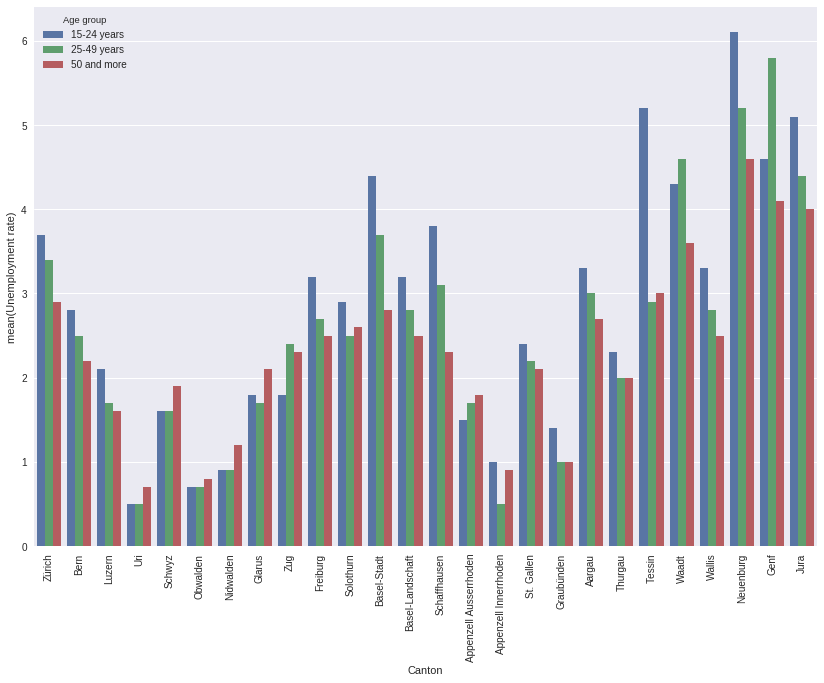

In [8]:
###part 3 by age ONLY
swiss_rate_age=pd.read_csv('DE_swiss_age.txt', sep="\t")
swiss_rate_age = swiss_rate_age.iloc[:, [0,2,4]]

#reformat to english
english_col_names=['Canton', 'Age group', 'Unemployment rate']
swiss_rate_age.columns=english_col_names
swiss_rate_age['Age group'] = swiss_rate_age['Age group'].str.replace('Jahre', 'years')
swiss_rate_age['Age group']= swiss_rate_age['Age group'].str.replace('und mehr', 'and more')
#remove 'Total row'
swiss_rate_age=swiss_rate_age.loc[swiss_rate_age['Canton'] != 'Gesamt']

#plotting
#Plot histogram
fig, ax = pyplot.subplots(figsize=(14.04, 9.924))
bar_plot=sns.barplot(x="Canton", y="Unemployment rate", hue="Age group", data=swiss_rate_age, ax=ax)
labels=bar_plot.get_xticklabels()
bar_plot=bar_plot.set_xticklabels(labels,rotation=90)